# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration / Image Undistortion

For additional info see "./camera_cal/CameraCalibrationImageUndistortionNotebook.ipynb"

In [100]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def calibrate(fname, nx=9, ny=6):
    objpoints = []
    imagepoints = []
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imagepoints.append(corners)
        objpoints.append(objp)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)
        return mtx, dist
    else:
        return None

def undistort(fname, mtx, dist):
    img = cv2.imread(fname)
    return cv2.undistort(img, mtx, dist, None, mtx)

### Applied on an example:

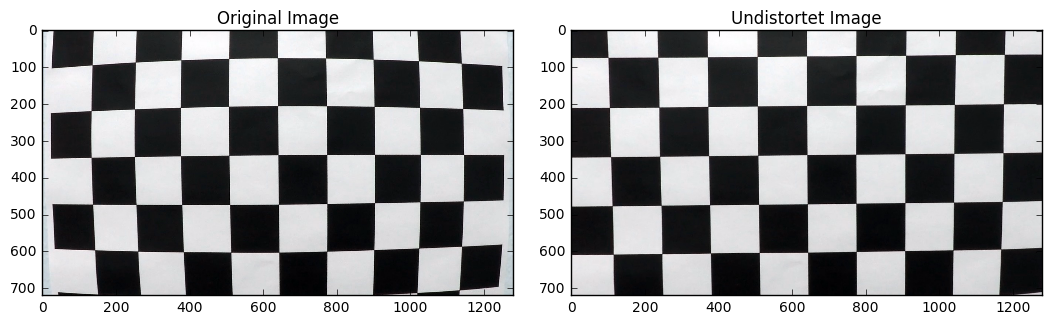

In [101]:
example_image = "./camera_cal/calibration1.jpg"
oimg = cv2.imread(example_image)
mtx, dist = calibrate(example_image, 9, 5)
uimg = undistort(example_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(uimg)
ax2.set_title('Undistortet Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholded Binary Image

* The original Image read via mpimg in the RGB colorspace

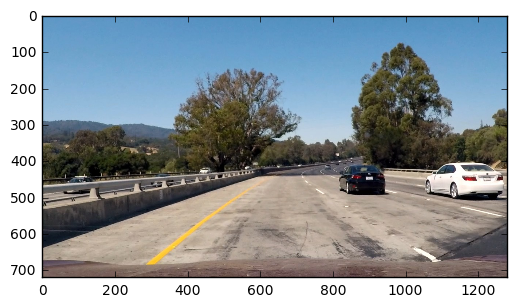

In [102]:
test_image = "./test_images/test1.jpg"
oimg = mpimg.imread(test_image)
plt.imshow(oimg)

* The original image compared to the undistortet image (BGR colorspace)

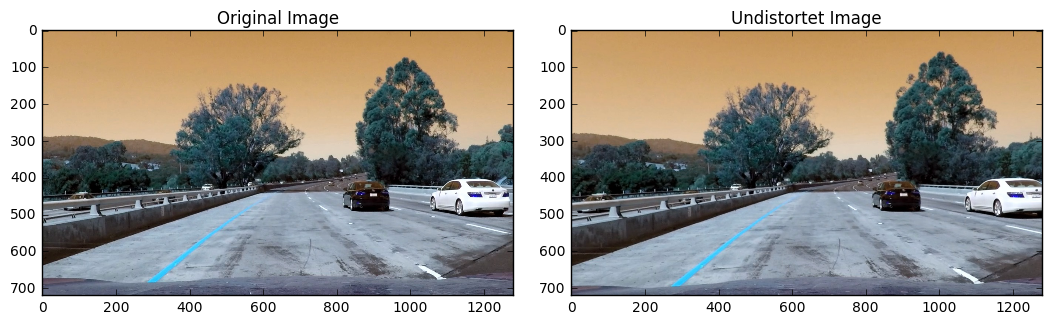

In [103]:
oimg = cv2.imread(test_image)
uimg = undistort(test_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(uimg)
ax2.set_title('Undistortet Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Several useful functions to experiment with

In [104]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt( sobelx**2 + sobely**2 )
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

ksize = 3
current_thresh = (20,100)

* Applying Sobel once in x and once in y orientation

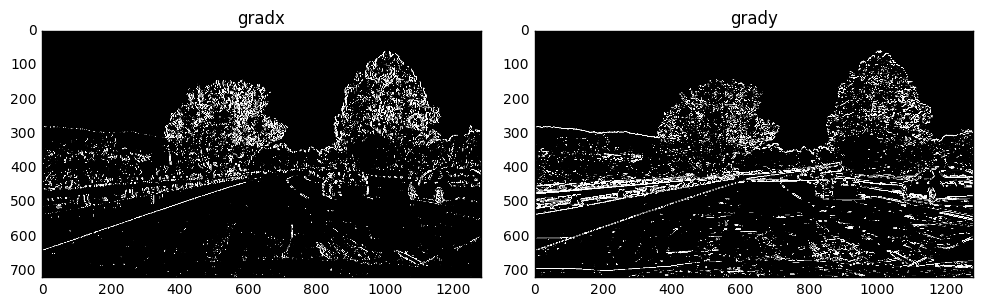

In [105]:
gradx = abs_sobel_thresh(uimg, orient='x', sobel_kernel=ksize, thresh=current_thresh)
grady = abs_sobel_thresh(uimg, orient='y', sobel_kernel=ksize, thresh=current_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(gradx, cmap="gray")
ax1.set_title('gradx', fontsize=12)
ax2.imshow(grady, cmap="gray")
ax2.set_title('grady', fontsize=12)

* Applying a threshold to the overall magnitude of the gradient, in x and y
* Direction of the gradient
* Combining the thresholds

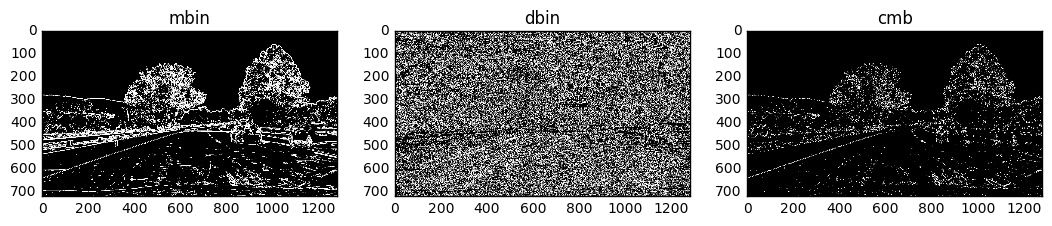

In [106]:
mag_binary = mag_thresh(uimg, sobel_kernel=ksize, thresh=current_thresh)
dir_binary = dir_threshold(uimg, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
f.tight_layout()
ax1.imshow(mag_binary, cmap="gray")
ax1.set_title('mbin', fontsize=12)
ax2.imshow(dir_binary, cmap="gray")
ax2.set_title('dbin', fontsize=12)
ax3.imshow(combined, cmap="gray")
ax3.set_title('cmb', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Combining gradient thresholding with HLS color space

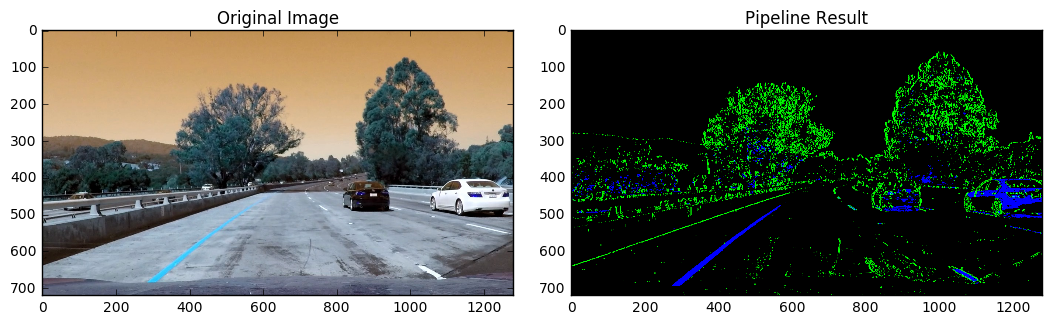

In [107]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(uimg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform